# Clustering with Aliens

In order to not offend earthlings present today 😃, I am going to generate an alien clustering problem.

In this notebook, we explore two critical parts of clustering:

## Distance

Distance is one of the most critical aspects of good clustering.  Developing distance measures is almost an art.  Getting the desired clusters is difficult.

That was shown with K-means where you have to choose the number of clusters.

## Algorithm

HDBSCAN is a varient of Scikit-Learns DBSCAN.  It is a density-based clustering method which uses certain measures to cluster without setting the the number of clusters.  What we will find is that choosing the size of the cluster is one of the driving features.

### HDBScan Documentation

[Here](https://media.readthedocs.org/pdf/hdbscan/latest/hdbscan.pdf)

In [1]:
!pip install hdbscan

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


For our aliens, we will get their skin color, sex (polyembryonic reproduce asexually), origins in the galaxy, profession, and favorite food.

In [2]:
alien_colors = ['green', 'black', 'red', 'white', 'purple']
alien_sexes = ['Polyembryonic', 'male', 'female'] # Polyembryonic only among red and purple species from the Orion Sector
alien_origins = ['Orion Sector', 'Sagitarians', 'Vulcans and Romulans', 'Clingons', 'Galactic Center', 'Naboo']
alien_jobs = ['explorer', 'army', 'translator', 'trader', 'doctor', 'banker', 'trans-warp mechanic', 'general mechanic',
              'counseler', 'mind control expert']
alien_favorite_foods = ['steak', 'chicken', 'chorizo', 'gagh', 'romulan mollusk', 'osol twist', 'gespar', 'plomeek soup',
                       'pipius claw', 'rokeg blood pie']

Randomly generate the sample.  (But we use a seed to always get the same result.)

In [3]:
import random
from random import randint
import numpy as np
import math

random.seed(42)

def genrandom(ilist):
    l = len(ilist)-1
    shift = math.ceil(l/2)
    r = -1
    while r < 0 or r > l:
        r = randint(0,l+(2*shift)) - shift
    return ilist[r]
    

samples = []

# Colors can be from any origin.  Polyembronic reproduction is only among red and purple in the Orion sector
# jobs given are in all origins.

def generate_sample():
    origin = genrandom(alien_origins)
    color = genrandom(alien_colors)
    sex_start = 1
    if origin == 'Orion Sector' and (color == 'red' or color =='purple'):
        sex_start = 0
    sex = genrandom(alien_sexes[sex_start:])
    job = genrandom(alien_jobs)
    fave_food = genrandom(alien_favorite_foods)
    return np.array([origin, color, sex, job, fave_food])

In [4]:
sample_size=1000
for i in range(sample_size):
    samples.append(generate_sample())
samples = np.array(samples)

In [5]:
print(samples[0:10,:])
print(samples.shape)

[['Sagitarians' 'black' 'male' 'counseler' 'chicken']
 ['Orion Sector' 'black' 'male' 'mind control expert' 'gagh']
 ['Clingons' 'white' 'female' 'army' 'osol twist']
 ['Clingons' 'white' 'female' 'trader' 'rokeg blood pie']
 ['Naboo' 'purple' 'female' 'trans-warp mechanic' 'chicken']
 ['Orion Sector' 'red' 'Polyembryonic' 'general mechanic' 'gagh']
 ['Galactic Center' 'white' 'male' 'trans-warp mechanic' 'gespar']
 ['Orion Sector' 'red' 'Polyembryonic' 'translator' 'steak']
 ['Galactic Center' 'purple' 'female' 'translator' 'osol twist']
 ['Orion Sector' 'white' 'female' 'army' 'osol twist']]
(1000, 5)


Is Polyembryonic reproduction rare?

In [6]:
len(samples[samples[:,2] == 'Polyembryonic'])/len(samples)

0.028

In [7]:
import hdbscan

!pip install -U scikit-learn

## Jaccard Similarity

The Jaccard Index or Similarity determines how similar two sets (in our case, data vectors) are:

$J(A,B) = \frac{|A \bigcap B|}{|A \bigcup B|}$

where the intersection is

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Intersection_of_sets_A_and_B.svg/371px-Intersection_of_sets_A_and_B.svg.png)

and the union is

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Union_of_sets_A_and_B.svg/371px-Union_of_sets_A_and_B.svg.png)

Note that $J(A,B)$ is between 0 and 1.  When the two sets are equal, the similarity is 1.  That means that the distance will be $1 - J(A,B)$ - we will try that out.

In [8]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import jaccard_similarity_score

In [9]:
class test_measure:
    def __call__(self, x, y):
        print('Normalize={}'.format(mnormalize))
        return jaccard_similarity_score(x, y, normalize = mnormalize, sample_weight=sweight)

What does normalization do?

In [10]:
index = None
for j in range(1,len(samples)):
    if samples[j][3] == samples[0][3]:
        index = j
        break
print('Sample A: {}'.format(samples[0]))
print('Sample B: {}'.format(samples[index]))

sweight=[1.0, 1.0, 1.0, 10, 1.0]

for mnormalize in [True, False]:
    m = test_measure()
    print('Distance={}\n'.format(m(samples[0], samples[index])))

Sample A: ['Sagitarians' 'black' 'male' 'counseler' 'chicken']
Sample B: ['Galactic Center' 'purple' 'male' 'counseler' 'gespar']
Normalize=True
Distance=0.7857142857142857

Normalize=False
Distance=11.0



When using weights, we should normalize.

Consider the effects of weights on the measure with the same two entities with variable weighting on color.

We suspect our current measure is similarity, not distance.  Let's check that out.

In [11]:
class test_measure:
    def __call__(self, x, y):
        return jaccard_similarity_score(x, y, normalize = True, sample_weight=sweight)

In [12]:
index = None
asample = samples[0].copy()
for c in alien_colors:
    if c != asample[1]:
        asample[1] = c
        break
print('Sample A: {}'.format(samples[0]))
print('Sample B: {}\n'.format(asample))

mnormalize = True

for i in range(4, 1, -1):
    sweight=[1.0, i*10, 1.0, 1.0, 1.0]
    m = test_measure()
    print('Weight:{} -> Similarity={}'.format(sweight, m(samples[0], asample)))

Sample A: ['Sagitarians' 'black' 'male' 'counseler' 'chicken']
Sample B: ['Sagitarians' 'green' 'male' 'counseler' 'chicken']

Weight:[1.0, 40, 1.0, 1.0, 1.0] -> Similarity=0.09090909090909091
Weight:[1.0, 30, 1.0, 1.0, 1.0] -> Similarity=0.11764705882352941
Weight:[1.0, 20, 1.0, 1.0, 1.0] -> Similarity=0.16666666666666666


We have confirmed that we have a measure of similarity.  For more details - the [Wikipedia](https://en.wikipedia.org/wiki/Jaccard_index) page is pretty good.

Redefine our weight function and run again.

In [13]:
class test_measured:
    def __call__(self, x, y):
        return 1.0 - jaccard_similarity_score(x, y, normalize = True, sample_weight=sweight)

In [14]:
print('Sample A: {}'.format(samples[0]))
print('Sample B: {}\n'.format(asample))

for i in range(61, 1, -5):
    sweight=[1.0, np.exp(i/10), 1.0, 1.0, 1.0]
    md = test_measured()
    print('Weight={} -> distance={}'.format(
        sweight, md(samples[0], asample)))

Sample A: ['Sagitarians' 'black' 'male' 'counseler' 'chicken']
Sample B: ['Sagitarians' 'green' 'male' 'counseler' 'chicken']

Weight=[1.0, 445.85777008251677, 1.0, 1.0, 1.0] -> distance=0.9911083007429964
Weight=[1.0, 270.42640742615254, 1.0, 1.0, 1.0] -> distance=0.9854241432611532
Weight=[1.0, 164.0219072999017, 1.0, 1.0, 1.0] -> distance=0.9761935805617274
Weight=[1.0, 99.484315641933776, 1.0, 1.0, 1.0] -> distance=0.9613467995107547
Weight=[1.0, 60.34028759736195, 1.0, 1.0, 1.0] -> distance=0.9378305545503343
Weight=[1.0, 36.598234443677988, 1.0, 1.0, 1.0] -> distance=0.9014735479310262
Weight=[1.0, 22.197951281441636, 1.0, 1.0, 1.0] -> distance=0.8473163051175853
Weight=[1.0, 13.463738035001692, 1.0, 1.0, 1.0] -> distance=0.7709539623199224
Weight=[1.0, 8.1661699125676517, 1.0, 1.0, 1.0] -> distance=0.6712194528971684
Weight=[1.0, 4.9530324243951149, 1.0, 1.0, 1.0] -> distance=0.5532240016130348
Weight=[1.0, 3.0041660239464334, 1.0, 1.0, 1.0] -> distance=0.42891130987979686
Weigh

Now the weight acts as we desire.  That is, we can add some weight to the variables we want to make them more important.  As we increase the weights, the distances are reduced.  This is how we prioritize certain factors.

In my case, I am less concerned about bias by color or sex and much more interested in grouping together beings by job and food preference.  That way they can work together and go out to the native deli for their favorite lunch.  Good way to build teamwork.  I do recognize that communication between aliens of different sectors may be difficult - in the galactic core, most communication is telepathic while in other parts of the galaxy, aliens still tend to use primitive languages.

In [15]:
class measure:
    def __call__(self, x, y):
        return 1.0 - jaccard_similarity_score(x, y, normalize=False, sample_weight=[2.0, 1.0, 1.0, 100.0, 50.0])

Generate ```X```, the precomputed distance matrix.

In [16]:
m = measure()
X = np.empty((sample_size,sample_size), dtype=np.float)
for i in range(0, sample_size):
    for j in range(0, sample_size):
        X[i,j] = m(samples[i], samples[j])

In [17]:
clusterer = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_method='eom')

The default cluster selection method is EOM.

In [18]:
clusterer.fit(X)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='precomputed', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

In [19]:
clusterer.labels_.max()

1

For this problem, EOM isn't very good - try leaf.

In [20]:
clusterer = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_method='leaf')

In [21]:
clusterer.fit(X)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='leaf',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='precomputed', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

How many clusters do we get with 'leaf'?

In [22]:
clusterer.labels_.max()

102

Good.  Well better.  That is a lot of clusters, but we have some things we can do.

How many points didn't get in a cluster?

In [23]:
print(len(clusterer.labels_[clusterer.labels_==-1]))

28


Sample some clusters.  Note that in the cluster we print out, every individual is in the same profession and loves the Romulan tart candy Osol Twist.

In [24]:
# Sample some clusters
print(samples[clusterer.labels_ == 20])

[['Naboo' 'black' 'male' 'mind control expert' 'osol twist']
 ['Naboo' 'black' 'female' 'mind control expert' 'osol twist']
 ['Naboo' 'green' 'female' 'mind control expert' 'osol twist']
 ['Vulcans and Romulans' 'purple' 'female' 'mind control expert'
  'osol twist']
 ['Galactic Center' 'green' 'male' 'mind control expert' 'osol twist']
 ['Vulcans and Romulans' 'white' 'male' 'mind control expert' 'osol twist']
 ['Naboo' 'purple' 'male' 'mind control expert' 'osol twist']
 ['Orion Sector' 'white' 'female' 'mind control expert' 'osol twist']
 ['Galactic Center' 'purple' 'female' 'mind control expert' 'osol twist']
 ['Sagitarians' 'black' 'male' 'mind control expert' 'osol twist']
 ['Galactic Center' 'black' 'female' 'mind control expert' 'osol twist']
 ['Clingons' 'purple' 'female' 'mind control expert' 'osol twist']
 ['Galactic Center' 'purple' 'female' 'mind control expert' 'osol twist']
 ['Galactic Center' 'white' 'male' 'mind control expert' 'osol twist']]


Perhaps the clusters are too fine grained?  We can adjust leaf size.

In [25]:
for leaf_size in [1, 5, 20, 100, 1000]:
    clusterer = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_method='leaf', leaf_size=leaf_size)
    clusterer.fit(X)
    print('leaf size={}, # of clusters = {}, number unclustered = {}'.format(
        leaf_size, clusterer.labels_.max(), len(clusterer.labels_[clusterer.labels_==-1])))

leaf size=1, # of clusters = 102, number unclustered = 28
leaf size=5, # of clusters = 102, number unclustered = 28
leaf size=20, # of clusters = 102, number unclustered = 28
leaf size=100, # of clusters = 102, number unclustered = 28
leaf size=1000, # of clusters = 102, number unclustered = 28


That didn't make a difference either - we can also control minimum cluster size - that could make a distance...

In [26]:
for min_size in [5, 20, 100, 1000]:
    clusterer = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_method='leaf', min_cluster_size=min_size)
    clusterer.fit(X)
    print('min cluster size={}, # of clusters = {}, number unclustered = {}'.format(
        min_size, clusterer.labels_.max(), len(clusterer.labels_[clusterer.labels_==-1])))

min cluster size=5, # of clusters = 102, number unclustered = 28
min cluster size=20, # of clusters = 19, number unclustered = 135
min cluster size=100, # of clusters = 6, number unclustered = 223
min cluster size=1000, # of clusters = -1, number unclustered = 1000


Let's try several minimum cluster sizes and see which gives a great configuration which we call a reasonable number of clusters with a low number of unclustered entities.

In [27]:
def cluster_optimize_function(minsz, clust):
    nw, uw = 0.5, 0.5
    d = clust.labels_.max()*nw + len(clust.labels_[clust.labels_==-1])*uw
    print('Min Cluster Size = {}, Number Clusters = {}, Number unclustered = {}, Sizing Metric={}'.format(\
           minsz, clust.labels_.max(), len(clust.labels_[clust.labels_==-1]), d))
    return d

In [28]:
min_size=None
dist = 1e10
for msize in [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]:
    clusterer = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_method='leaf', min_cluster_size=msize)
    clusterer.fit(X)
    d = cluster_optimize_function(msize, clusterer)
    if d < dist:
        dist = d
        min_size = msize
print('The optimal minimum size is {}'.format(min_size))

Min Cluster Size = 8, Number Clusters = 73, Number unclustered = 118, Sizing Metric=95.5
Min Cluster Size = 10, Number Clusters = 56, Number unclustered = 179, Sizing Metric=117.5
Min Cluster Size = 12, Number Clusters = 41, Number unclustered = 175, Sizing Metric=108.0
Min Cluster Size = 14, Number Clusters = 27, Number unclustered = 167, Sizing Metric=97.0
Min Cluster Size = 16, Number Clusters = 28, Number unclustered = 217, Sizing Metric=122.5
Min Cluster Size = 18, Number Clusters = 22, Number unclustered = 158, Sizing Metric=90.0
Min Cluster Size = 20, Number Clusters = 19, Number unclustered = 135, Sizing Metric=77.0
Min Cluster Size = 22, Number Clusters = 18, Number unclustered = 78, Sizing Metric=48.0
Min Cluster Size = 24, Number Clusters = 19, Number unclustered = 102, Sizing Metric=60.5
Min Cluster Size = 26, Number Clusters = 15, Number unclustered = 51, Sizing Metric=33.0
Min Cluster Size = 28, Number Clusters = 13, Number unclustered = 51, Sizing Metric=32.0
Min Cluster

In [29]:
clusterer = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_method='leaf', min_cluster_size=min_size)
clusterer.fit(X)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='leaf',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='precomputed', min_cluster_size=44, min_samples=None, p=None,
    prediction_data=False)

In [30]:
for cnum in range(1, clusterer.labels_.max()+1):
    subc = samples[clusterer.labels_ == cnum]
    print('Group # {}, Size={}, Unique Careers={},\n  Favorite Foods={}\n'.format(
        cnum, len(subc), np.unique(subc[:,3]), np.unique(subc[:,4])))

Group # 1, Size=91, Unique Careers=['trader'],
  Favorite Foods=['chicken' 'chorizo' 'gagh' 'gespar' 'osol twist' 'pipius claw'
 'plomeek soup' 'rokeg blood pie' 'romulan mollusk' 'steak']

Group # 2, Size=97, Unique Careers=['translator'],
  Favorite Foods=['chicken' 'chorizo' 'gagh' 'gespar' 'osol twist' 'pipius claw'
 'plomeek soup' 'rokeg blood pie' 'romulan mollusk' 'steak']

Group # 3, Size=97, Unique Careers=['army'],
  Favorite Foods=['chicken' 'chorizo' 'gagh' 'gespar' 'osol twist' 'pipius claw'
 'plomeek soup' 'rokeg blood pie' 'romulan mollusk' 'steak']

Group # 4, Size=85, Unique Careers=['trans-warp mechanic'],
  Favorite Foods=['chicken' 'chorizo' 'gagh' 'gespar' 'osol twist' 'pipius claw'
 'plomeek soup' 'rokeg blood pie' 'romulan mollusk' 'steak']

Group # 5, Size=113, Unique Careers=['mind control expert'],
  Favorite Foods=['chicken' 'chorizo' 'gagh' 'gespar' 'osol twist' 'pipius claw'
 'plomeek soup' 'rokeg blood pie' 'romulan mollusk' 'steak']

Group # 6, Size=102, 

I like this grouping.  Now let's make sure that everybody can communicate.  To do so, we use the concept of a [language similarity score](https://en.wikipedia.org/wiki/Lexical_similarity).

Here are the regions of the galaxy that we have:

In [31]:
print(alien_origins)

['Orion Sector', 'Sagitarians', 'Vulcans and Romulans', 'Clingons', 'Galactic Center', 'Naboo']


Create a language similarity table:

In [32]:
import pandas as pd
from IPython.display import display 

x = \
np.array([[1.0, 0.1, 0.7, 0.4, 0.04, 0.2],
          [0.1, 1.0, 0.15, 0.22, 0.8, 0.6],
          [0.7, 0.15, 1.0, 0.7, 0.2, 0.4],
          [0.4, 0.22, 0.7, 1.0, 0.08, 0.02],
          [0.04, 0.8, 0.2, 0.08, 1.0, 0.6],
          [0.2, 0.6, 0.4, 0.02, 0.6, 1.0]])
similarity = pd.DataFrame(x)
similarity.columns = alien_origins
similarity.rename(index={0:alien_origins[0],1:alien_origins[1], 2:alien_origins[2],
                         3:alien_origins[3],4:alien_origins[4], 5:alien_origins[5]}, inplace=True)
display(similarity)

,Orion Sector,Sagitarians,Vulcans and Romulans,Clingons,Galactic Center,Naboo
Orion Sector,1.00,0.10,0.70,0.40,0.04,0.20
Sagitarians,0.10,1.00,0.15,0.22,0.80,0.60
Vulcans and Romulans,0.70,0.15,1.00,0.70,0.20,0.40
Clingons,0.40,0.22,0.70,1.00,0.08,0.02
Galactic Center,0.04,0.80,0.20,0.08,1.00,0.60
Naboo,0.20,0.60,0.40,0.02,0.60,1.00


Now we need to find a way to mix our Jaccard distance with a distance such as Euclidean or Manhatten (or others) for continuous distances.  One such measure is Gower's distance which mixes Jaccard (or Dice) with Manhatten.  Let's create the appropriate measure function.

Choosing a distance measure becomes tricky.  You'll notice that some parameters have changed.  What I really want is to cluster on language compatability, profession, and favorite food.

When is it right?  That seems to be a judgement call, often based on business requirements.

### On Gower's Distance

Actually, with just one continuous scalar, we can't implement Manhatten or Euclidean measures - they are the same.

By the way - this [R-bloggers](https://www.r-bloggers.com/clustering-mixed-data-types-in-r/) also gets into a discussion about clustering and distances along with Gower's distance.

#### [Manhattan Distance](https://en.wikipedia.org/wiki/Taxicab_geometry)

The Manhattan distance is also known as the Taxicab distance as it is depicted as a Taxicab trying to get to a diagonal location in Manhattan:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Manhattan_distance.svg/300px-Manhattan_distance.svg.png)

and is formally defined as

$d_1(p,q) = \sum_{i=1}^n (p_i - q_i)$

#### Euclidean

We are familiar with it already -

$d_2(p,q) = \sqrt{\sum_{i=1}^n (p_i - q_i)^2}$

If we only have one feature with continuous measure, then it is pretty easy to see (with n=1) that $d_1(p,q) = d_2(p,q)$.

Define the new measure function evenly weighting the importance of language to the previous feature set.

In [33]:
class measure:
    def __call__(self, x, y):
        language_distance = 1.0 - similarity.loc[x[0],y[0]]
        set_distance = 1.0 - jaccard_similarity_score(x, y, normalize=True, sample_weight=[1.0, 1.0, 1.0, 80.0, 40.0])
        # Both measures scale from 0 to 1.  We will return a linear combination of the scores for the final score.
        language_importance = 0.5
        return language_importance * language_distance + (1-language_importance)*set_distance

Test it just to make sure I did my math/coding correct.  We should get zero distance for the same individual.

In [34]:
m = measure()
print(m(samples[0], samples[0]))

0.0


Generate ```X```, the precomputed distance matrix.  We are going to note that the matrix is symmetric so we can speed up our calculating a bit.

This should cause beepers, lights, and horns to go off which we come back to!

In [35]:
m = measure()
X = np.empty((sample_size,sample_size), dtype=np.float)
for i in range(0, sample_size):
    for j in range(i, sample_size):
        X[i,j] = X[j,i] = m(samples[i], samples[j])

Run clustering as before, but with a few modifications.

In [36]:
min_size=None
dist = 1e10
for msize in [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]:
    clusterer = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_method='leaf', min_cluster_size=msize)
    clusterer.fit(X)
    d = cluster_optimize_function(msize, clusterer)
    if d < dist:
        dist = d
        min_size = msize
print('The optimal minimum size is {}'.format(min_size))

Min Cluster Size = 8, Number Clusters = 54, Number unclustered = 72, Sizing Metric=63.0
Min Cluster Size = 10, Number Clusters = 44, Number unclustered = 83, Sizing Metric=63.5
Min Cluster Size = 12, Number Clusters = 38, Number unclustered = 99, Sizing Metric=68.5
Min Cluster Size = 14, Number Clusters = 35, Number unclustered = 89, Sizing Metric=62.0
Min Cluster Size = 16, Number Clusters = 25, Number unclustered = 165, Sizing Metric=95.0
Min Cluster Size = 18, Number Clusters = 21, Number unclustered = 216, Sizing Metric=118.5
Min Cluster Size = 20, Number Clusters = 17, Number unclustered = 114, Sizing Metric=65.5
Min Cluster Size = 22, Number Clusters = 15, Number unclustered = 81, Sizing Metric=48.0
Min Cluster Size = 24, Number Clusters = 17, Number unclustered = 48, Sizing Metric=32.5
Min Cluster Size = 26, Number Clusters = 18, Number unclustered = 53, Sizing Metric=35.5
Min Cluster Size = 28, Number Clusters = 17, Number unclustered = 95, Sizing Metric=56.0
Min Cluster Size =

In [37]:
min_size=24
clusterer = hdbscan.HDBSCAN(metric='precomputed', cluster_selection_method='leaf', min_cluster_size=min_size)
clusterer.fit(X)
print('min cluster size={}, # of clusters = {}, number unclustered = {}'.format(
    min_size, clusterer.labels_.max(), len(clusterer.labels_[clusterer.labels_==-1])))

min cluster size=24, # of clusters = 17, number unclustered = 48


Create a DataFrame with some characteristics of the clusters.

In [38]:
from collections import OrderedDict

cdf = None
for cnum in range(0, clusterer.labels_.max()+1):
    c_cluster = samples[clusterer.labels_ == cnum]
    ostr = ', '.join(np.unique(c_cluster[:,0]))
    pstr = ', '.join(np.unique(c_cluster[:,3]))
    fstr = ', '.join(np.unique(c_cluster[:,4]))

    tdf = pd.DataFrame([[len(c_cluster), ostr, pstr, fstr]],
                       columns=['Size', 'Origins', 'Professions', 'Favorite Foods'])
    if cdf is None:
        cdf = tdf
    else:
        cdf = cdf.append(tdf, ignore_index=True)

cdf.reindex(['Origins', 'Professions', 'Favorite Foods'])
display(cdf)


,Size,Origins,Professions,Favorite Foods
0,59,Naboo,"army, doctor, explorer, general mechanic, mind...","chicken, chorizo, gagh, gespar, osol twist, pi..."
1,98,"Clingons, Galactic Center, Naboo, Orion Sector...",counseler,"chicken, chorizo, gagh, gespar, osol twist, pi..."
2,50,"Clingons, Orion Sector, Vulcans and Romulans",translator,"chicken, chorizo, gagh, gespar, osol twist, pi..."
3,75,"Clingons, Galactic Center, Naboo, Orion Sector...",trader,"chicken, chorizo, gagh, gespar, osol twist, pi..."
4,28,"Galactic Center, Sagitarians",trans-warp mechanic,"chicken, chorizo, gagh, gespar, osol twist, pi..."
5,33,"Galactic Center, Sagitarians",doctor,"chicken, chorizo, gespar, osol twist, pipius c..."
6,53,"Galactic Center, Naboo, Sagitarians","army, counseler, general mechanic, mind contro...","chicken, chorizo, gagh, gespar, osol twist, pi..."
7,35,"Galactic Center, Sagitarians",translator,"chicken, chorizo, gagh, gespar, osol twist, pi..."
8,45,"Galactic Center, Sagitarians",explorer,"chicken, chorizo, gagh, gespar, osol twist, pi..."
9,100,"Clingons, Galactic Center, Naboo, Orion Sector...",mind control expert,"chicken, chorizo, gagh, gespar, osol twist, pi..."


The details of how HDBScan works is given in the [HDB Documentation](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html).  Essentially, points are connected by a minimum spanning tree using Prim's algorithm.  With that, a cluster hierarchy can built from which can be formed varying number of clusters.  That hierarchy is represented by looking a a linkage tree.

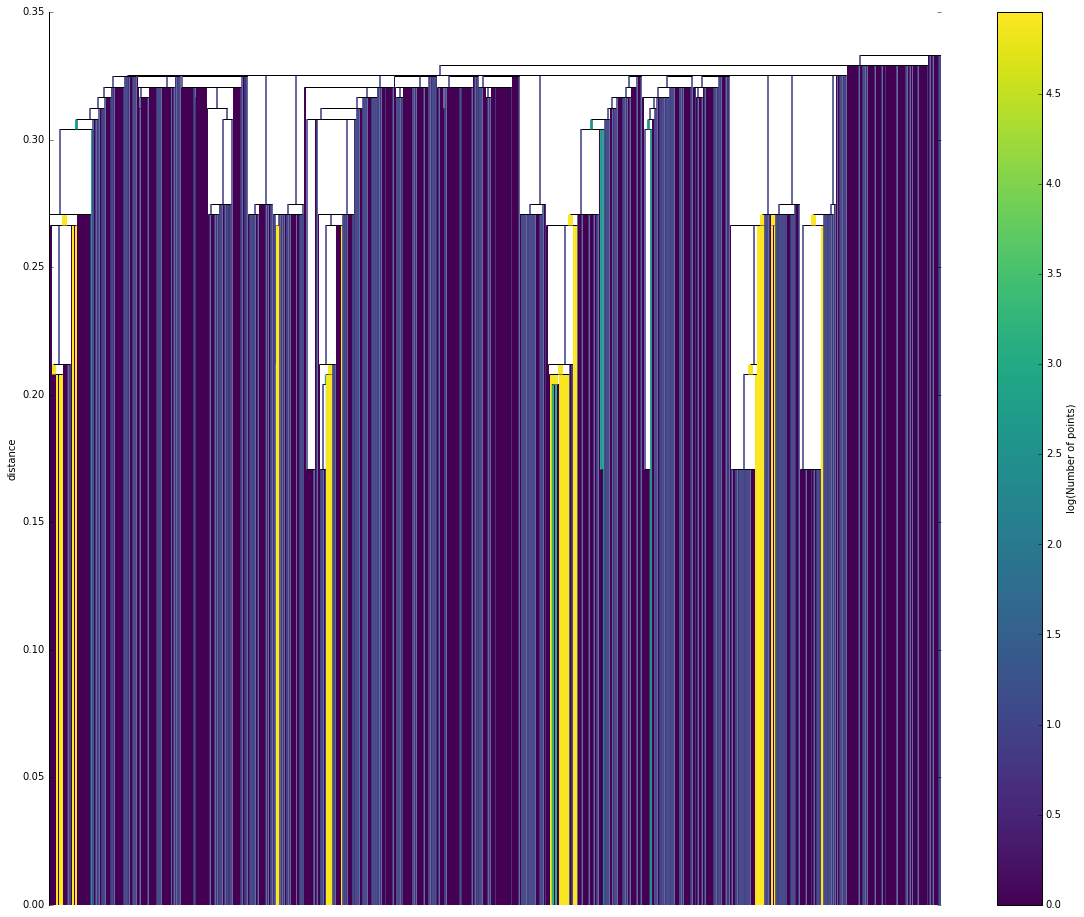

In [39]:
%matplotlib inline

import matplotlib

matplotlib.rcParams['figure.figsize'] = [20, 16]

clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

Recall that previously we discussed T-sne and its uses.  Unless you are some sort of savant, it is not possible to visualize a n-dimensional space full of points where n is greater than 3.  That's where we can use T-sne to transform the problem in n-dimensions down into a 2 or 3-dimensional space.

In [40]:
from sklearn.manifold import TSNE
tsne = TSNE(early_exaggeration=12, perplexity=50)
embedded = tsne.fit_transform(X)

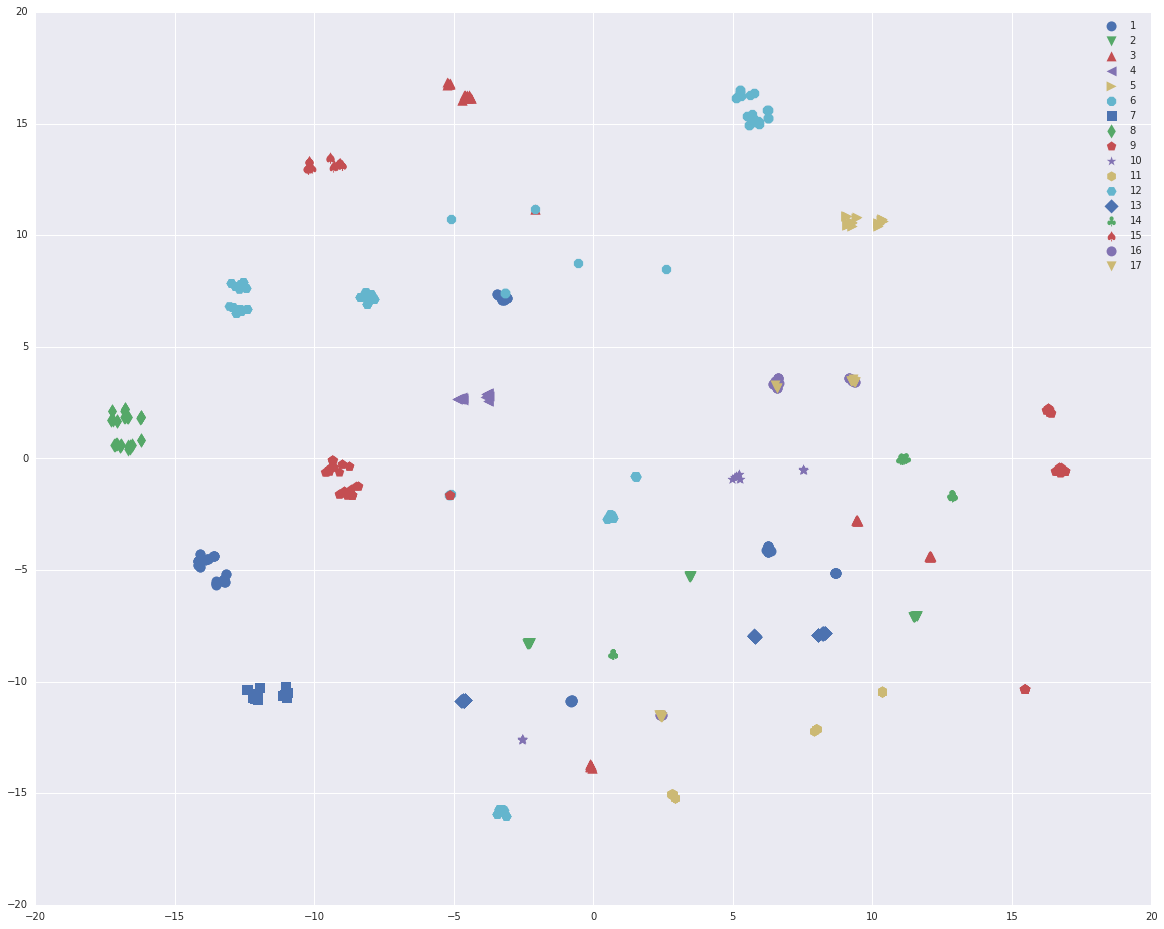

In [41]:
import seaborn as sns
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [20, 16]

color_palette = sns.color_palette('deep', clusterer.labels_.max()+1)
marker_palette = ['o', 'v', '^', '<', '>', '8', 's', 'd', 'p', '*', 'h', 'H', 'D', '$\clubsuit$',
                  '$\spadesuit$']
marker_palette = marker_palette + marker_palette


fig, ax = plt.subplots()
for cnum in range(1, clusterer.labels_.max()+1):
    c_cluster = samples[clusterer.labels_ == cnum]
    points = embedded[clusterer.labels_ == cnum]
    ax.scatter(points[:,0], points[:,1], s=100, linewidth=0, label=cnum,
               c=color_palette[cnum-1], marker=marker_palette[cnum-1])
ax.legend()
plt.show()

It is very difficult to see the clusters in two dimensions for our dataset.  But T-sne also will do manifold learning into three dimensions.  I like this article on visualization for T-sne: https://distill.pub/2016/misread-tsne/

In [42]:
# 8, 30 pretty good
tsne = TSNE(n_components=3, early_exaggeration=8, perplexity=30)
embedded = tsne.fit_transform(X)

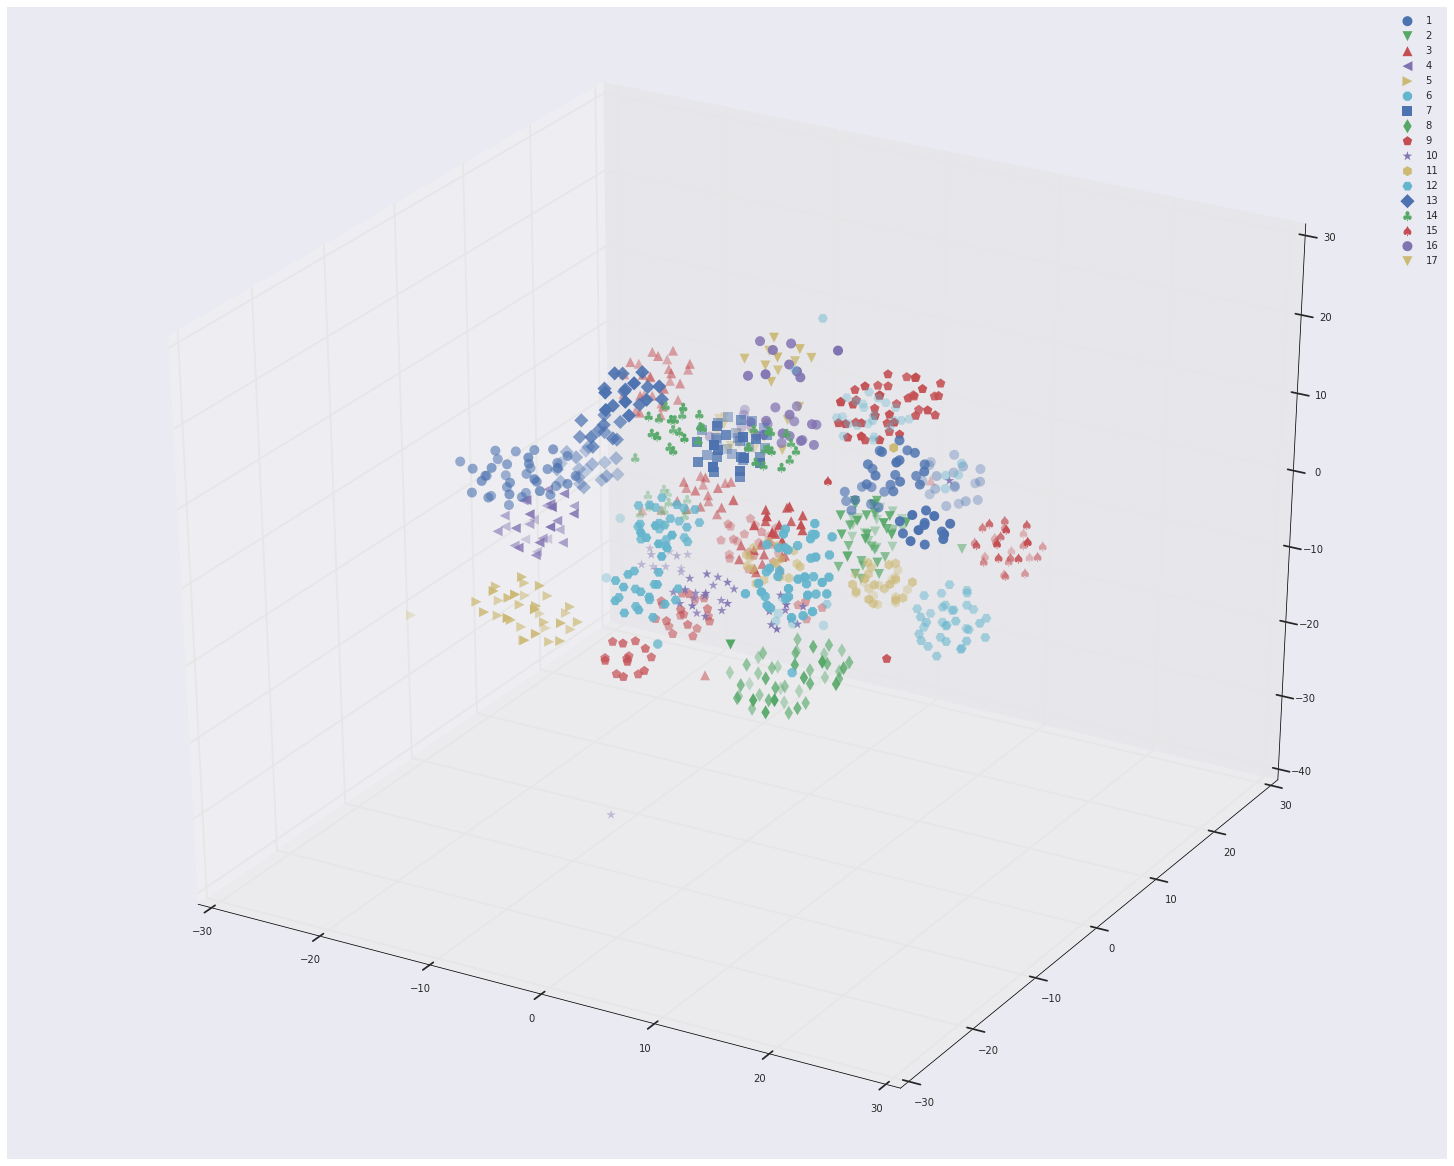

In [43]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['figure.figsize'] = [20, 16]

color_palette = sns.color_palette('deep', clusterer.labels_.max()+1)
marker_palette = ['o', 'v', '^', '<', '>', '8', 's', 'd', 'p', '*', 'h', 'H', 'D', '$\clubsuit$',
                  '$\spadesuit$']
marker_palette = marker_palette + marker_palette

fig = plt.figure()

ax = Axes3D(fig)
for cnum in range(1, clusterer.labels_.max()+1):
    c_cluster = samples[clusterer.labels_ == cnum]
    points = embedded[clusterer.labels_ == cnum]
    ax.scatter(points[:,0], points[:,1], points[:,2], s=100, linewidth=0, label=cnum,
               c=color_palette[cnum-1], marker=marker_palette[cnum-1])
ax.legend()
plt.show()

# Exemplars

Exemplars and represent the "center" points of the cluster (regardless of the shape).   They are most representative of the typical population in the cluster.  More details [here](https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html).

Thinking about our problem, we note that we have limited features so we expect that our Jaccard distances as well as our language similarity factors to have a level of discontinuity.  The more continuous the measures, the more likely we are to get a better scattering of points (which we aren't seeing).

Also, perhaps in my generation of the problem, I managed to create a problem that clusters well.  I suspect that since we have a limited number of features, the problem ends up much better behaved.

We should see that the number of exemplars will make up a large percentage of the total number of data points in the group.

In [44]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) &
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

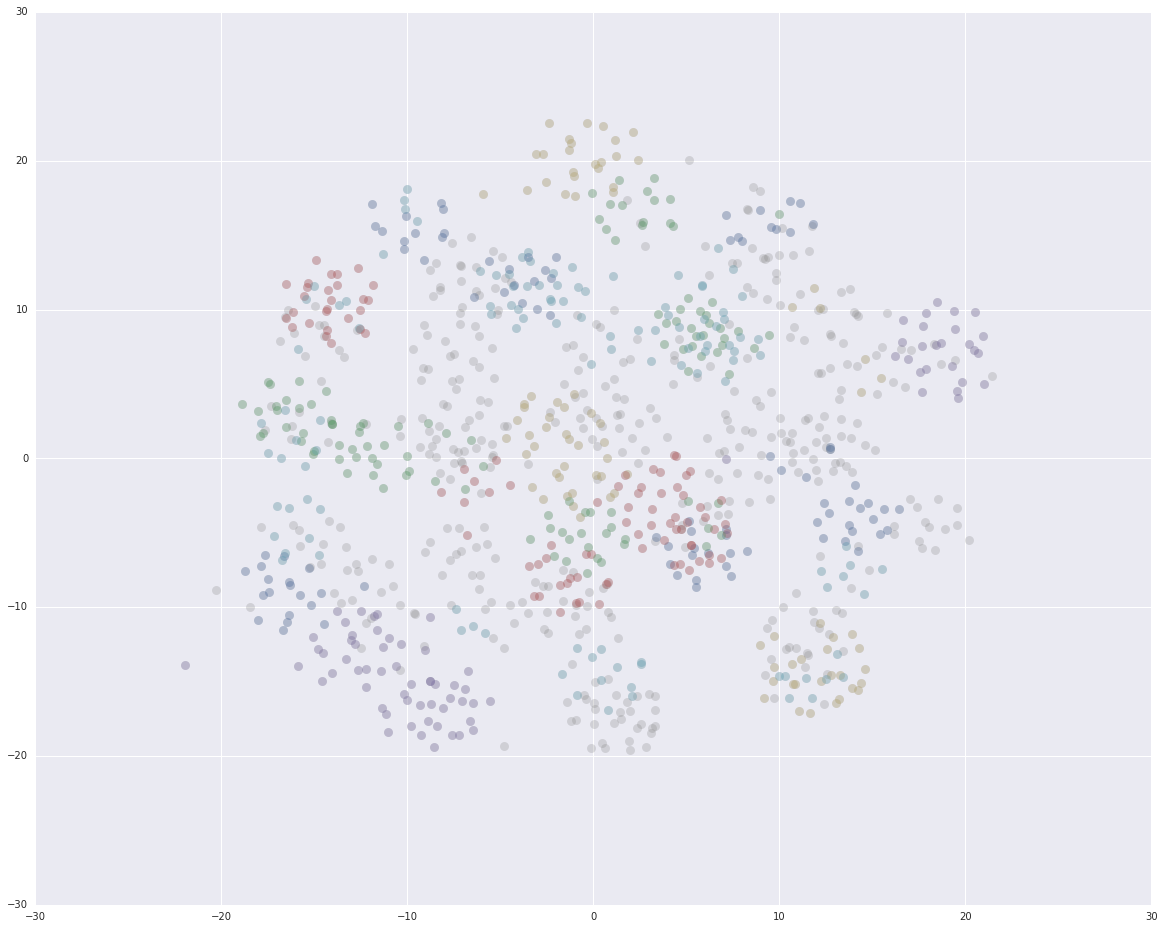

In [45]:
matplotlib.rcParams['figure.figsize'] = [20, 16]

tree = clusterer.condensed_tree_
plot_kwds={'alpha':0.25, 's':80, 'linewidths':0}
plt.scatter(embedded[:,0], embedded[:,1], c='grey', **plot_kwds)
cdf = None
for i, c in enumerate(tree._select_clusters()):
    c_cluster = samples[clusterer.labels_ == i]
    c_exemplars = exemplars(c, tree)
    tdf = pd.DataFrame([[i, c, len(c_cluster), c_exemplars.shape[0]]],
                columns=['Cluster Label', 'Cluster ID', 'Cluster Size', 'Number Exemplars'])
    if cdf is None:
        cdf = tdf
    else:
        cdf = cdf.append(tdf, ignore_index=True)

    
    plt.scatter(embedded[c_exemplars][:,0], embedded[c_exemplars][:,1], c=color_palette[i], **plot_kwds)

In [46]:
display(cdf)

,Cluster Label,Cluster ID,Cluster Size,Number Exemplars
0,0,1009,59,30
1,1,1010,98,42
2,2,1011,50,27
3,3,1012,75,28
4,4,1017,28,34
5,5,1021,33,27
6,6,1025,53,39
7,7,1029,35,40
8,8,1031,45,38
9,9,1032,100,26


It is interesting that in some cases, we have more exemplars than points in the cluster (Cluster labels 4, 7, 17).  I don't know why that is.

# Soft Clustering

Soft or fuzzy clustering (see the [documentation](https://media.readthedocs.org/pdf/hdbscan/latest/hdbscan.pdf)) is the probability of a point landing in a data cluster.

Currently, the program authors admit there are some issues with how well soft clustering is working.

My fellow data scientist Hongyu Guo hit upon an interesting idea for clustering based on a more probabilistic approach.  It is based on the fact that what we really want to know is the probability of a data point belonging to any of the clusters.

Here is a quick outline of the algorithm:

Given some data point p as input



For the $k^{th}$ cluster in clusters:      
>   get the exammplar points [e]  
>   Calculate the distance for each examplar point e to p.  
>   Calculate the mean distance and set to $D_k$  

The probability that a point is in cluster $k$ is $\frac{D_k}{\sum_i D_i}$

# Drawbacks

Precalculating a matrix obviously has its flaws, the most obvious being that of working with very large data sets.  The matrix for one million points takes up 8 terabytes of memory.

It would be cool if we could do this...

In [47]:
from numpy import memmap

filename = 'Xmemory.mem'
xmem = np.memmap(filename, dtype='float32', mode='w+', shape=(1000,1000))
xmem = X

because our matrix then is mapped onto a file on disk and all our troubles go away.  Unfortunately, HDBScan copies the matrix internally instead of just using it.

An even better approach would be if we could just pass the measure function into the code and whenever the measure had to occur between the ith and jth data points, the function would be called.  That would be cool except that internally HDBScan is hampered by the use of numpy's ```pairwise_distances``` (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) which only takes real numbers.

< soapbox >  
Honestly, a well-designed software puts the honus on the developer to provide a metric that will output a real number regardless of what the input object is (e.g., vector with any type of data).  This generates a very powerful and capable method.  Current clustering methods just don't appear to be designed that way - at least not DBScan or HDBScan!  
< /soapbox >

Our problem stemmed from the fact that we wanted to use Gower's distance which consisted of two metrics depending on the class of feature.  Nevertheless, HDBScan does support a very rich set of metrics:

braycurtis, canberra, chebyshev, cityblock, dice, euclidean, hamming, haversine, infinity,
jaccard, kulsinski, l1, l2, mahalanobis, manhattan, matching, minkowski, p, pyfunc, rogerstanimoto
russellrao, seuclidean, sokalmichener, sokalsneath, wminkowski

As a reference use [this for HDBScan](https://media.readthedocs.org/pdf/hdbscan/latest/hdbscan.pdf) and [this](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) for more on distances.